In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import numpy as np
import json

from sklearn.manifold import TSNE
from collections import deque
import math

In [2]:
LOG_FORMAT = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, "info".upper()))

In [3]:
rnn = "lstm"
data_name = "palindrome"
dir_name = "separator_Ctype4_30"
pretrained_dir_name = None
select = "1"

train_path = "data/"+data_name+"_rand/correction_"+dir_name+"/data_train.txt"
dev_path = "data/"+data_name+"_rand/correction_"+dir_name+"/data_test.txt"
config_path = "models/config.json"

# Prepare dataset

In [4]:
max_len = 65
src = fields.SourceField()
tgt = fields.TargetField()
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [6]:
optimizer = "Adam"
seq2seq = None
config_json = open(config_path).read()
config = json.loads(config_json)
config["max_len"] = max_len
config["hidden_size"] = 100
config["rnn_cell"] = rnn
config["embedding_size"] = 20
config["use_attention"] = True
config["position_embedding"] = "length"
config["use_memory"] = "queue"
#config["pos_add"] = "cat"

print(json.dumps(config, indent=4))

save_path = (data_name + "_rand_" + dir_name
            + ("_att" if config["use_attention"] else "")
            + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
            + ("_cat" if config["pos_add"] == "cat" else "")
            + ("_use_stack" if config["use_memory"] == "stack" else "")
            + ("_use_queue" if config["use_memory"] == "queue" else "")
            + "_emb" + str(config["embedding_size"])
            + "_hidden" + str(config["hidden_size"])
            + ("_pretrained" if pretrained_dir_name is not None else ""))
print("Save_path : %s" % save_path)
        
if pretrained_dir_name is not None:
    pretrained_path = ("pretrained_weights/"+ data_name + "_rand_" + pretrained_dir_name
            + ("_att" if config["use_attention"] else "")
            + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
            + ("_cat" if config["pos_add"] == "cat" else "")
            + ("_use_stack" if config["use_memory"] == "stack" else "")
            + ("_use_queue" if config["use_memory"] == "queue" else "")
            + "_emb" + str(config["embedding_size"])
            + "_hidden" + str(config["hidden_size"])
            + "_"+rnn+"_"+str(i))
    pretrained_pos_weight = np.load(pretrained_path+"/pretrained_pos_weight.npy")
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id,
                    pretrained_pos_weight)
else :
    seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)

{
    "max_len": 65,
    "embedding_size": 20,
    "hidden_size": 100,
    "input_dropout_p": 0,
    "dropout_p": 0,
    "n_layers": 1,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "position_embedding": "length",
    "pos_add": "add",
    "use_memory": "queue",
    "memory_dim": 5
}
Save_path : palindrome_rand_separator_Ctype4_30_att_with_pos_length_use_queue_emb20_hidden100


# Initialize model

In [7]:
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)
            
log_path = "log/pth/"+save_path +"_" + rnn + "_" + str(select) + "_model_save.pth"
seq2seq.load_state_dict(torch.load(log_path))
seq2seq.eval()

predictor = Predictor(seq2seq, input_vocab, output_vocab)

# Answer function

In [8]:
def answer_function(data):
    results = []
    words = data.split("#")
    comp = []
    result = ""
    
    for i in range(len(words[0])):
        result += "0"
        comp.append(words[0][i])
    result += "#"
    for i in range(len(words[1])):
        w = comp.pop()
        if words[1][i] != w:
            if w == "a":
                result += "1"
            elif w == "b":
                result += "2"
            elif w == "c":
                result += "3"
            elif w == "d":
                result += "4"
            else:
                result += "0"
        else:
            result += "0"
            
    results.append(result)

    return " ".join("#".join(results))

# Step function

In [9]:
def step_function(x):
    
    if x > 0:
        if x < 0.5:
            return 0
        else:
            return 1
    else:
        if x > -0.5:
            return 0
        else:
            return -1

# Position

In [10]:
fig_path = "log/visualize/" + save_path
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)
fig_path = fig_path + "/" + rnn
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)

# Predict

input  : c d d a c b c d d a # a c d c b a a d d c


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Answer : 0 0 0 0 0 0 0 0 0 0 # 0 4 0 0 0 3 0 0 0 0
predict: 0 0 0 0 0 0 0 0 0 0 # 0 4 0 0 0 3 0 0 0 0 <eos>


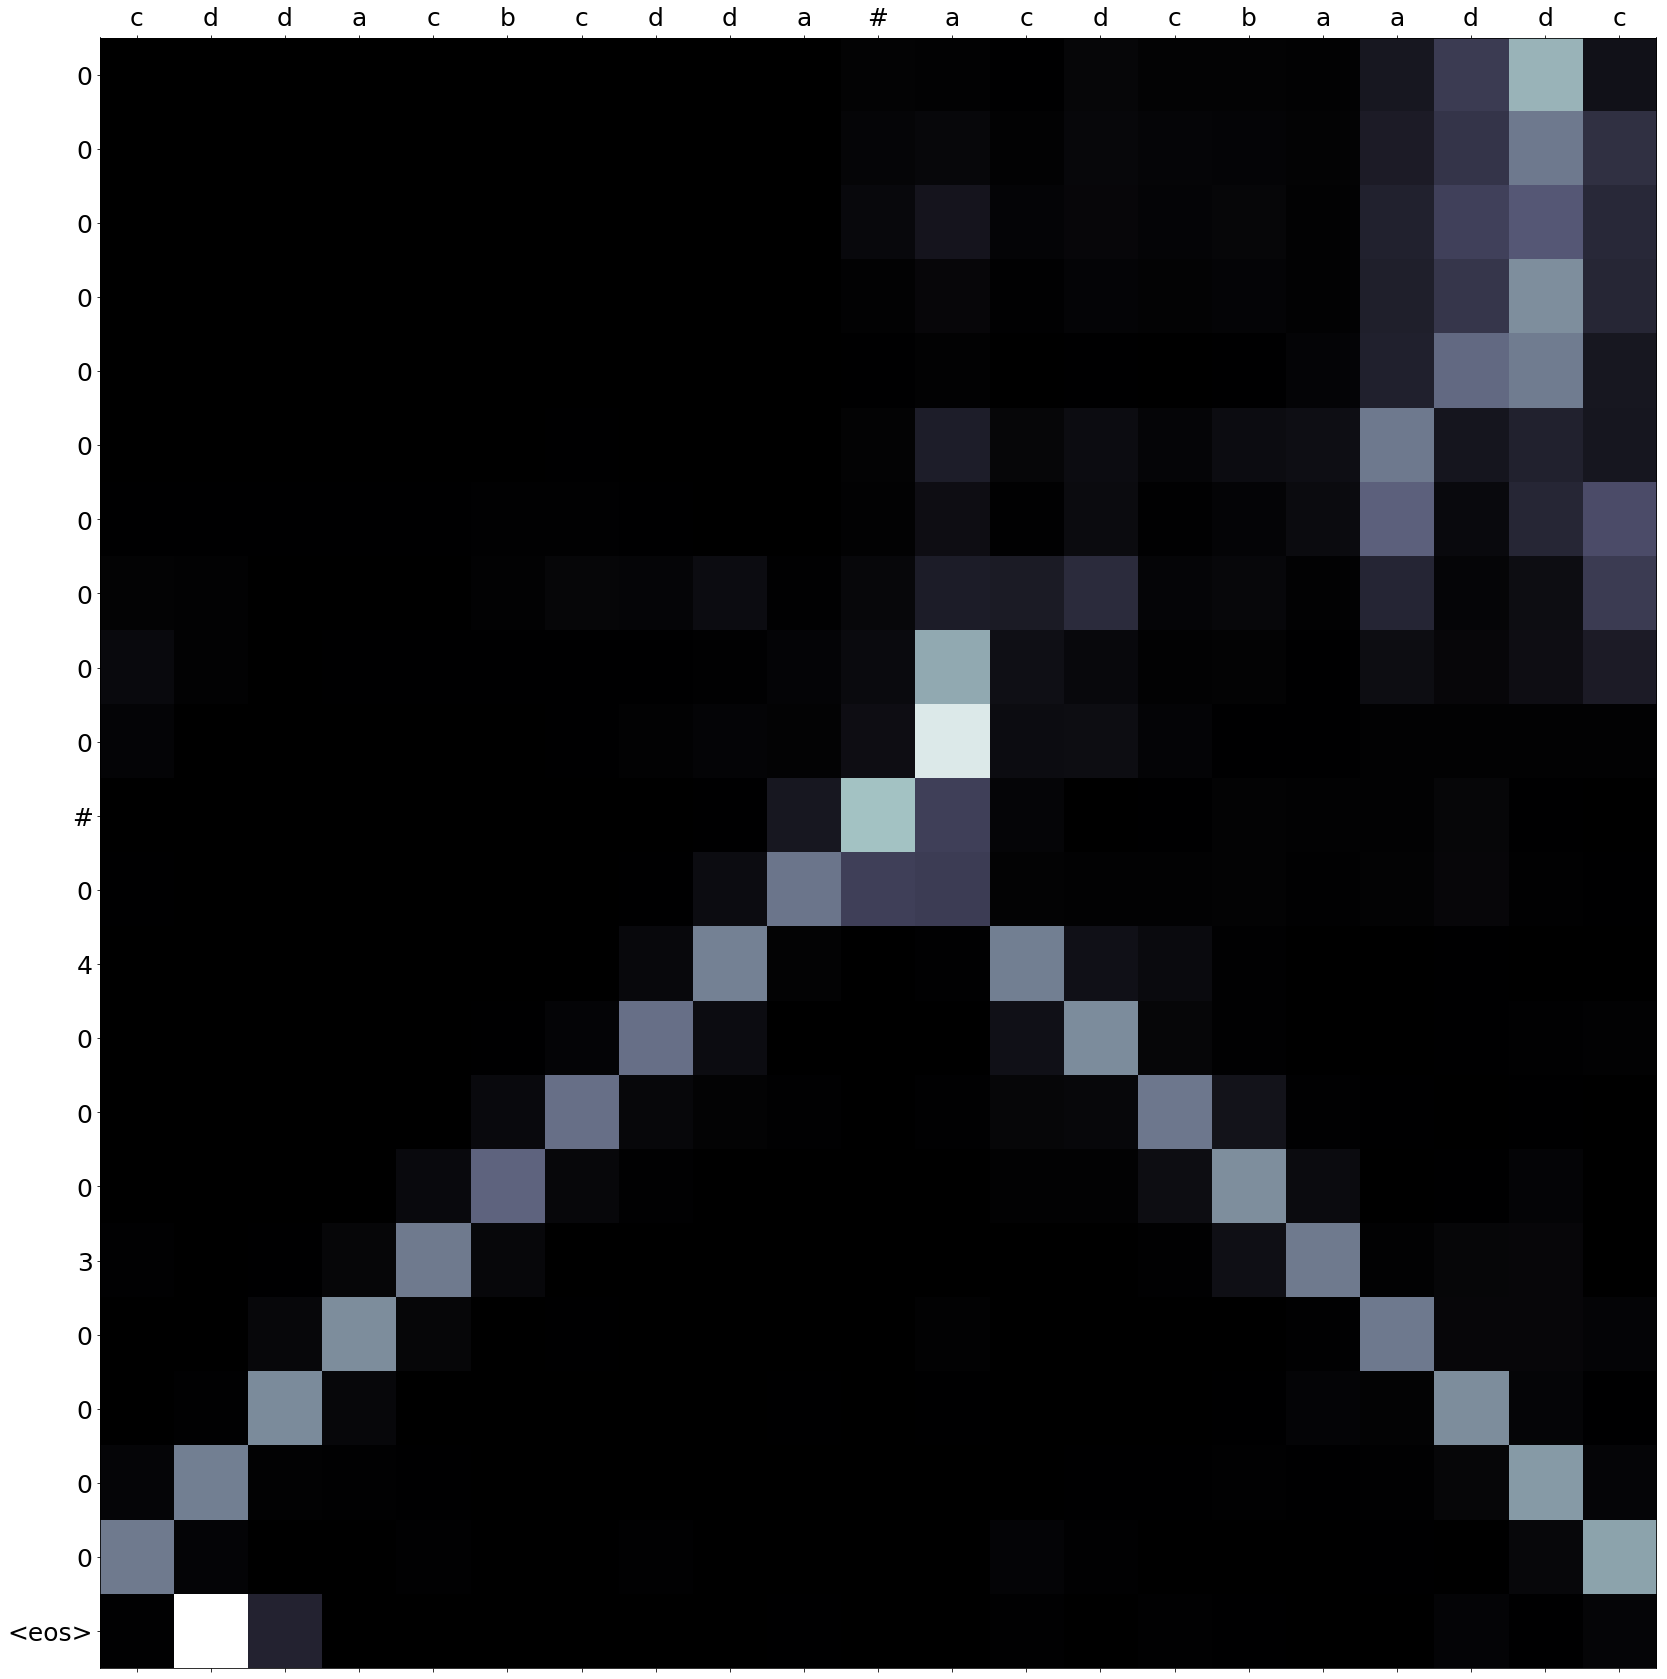

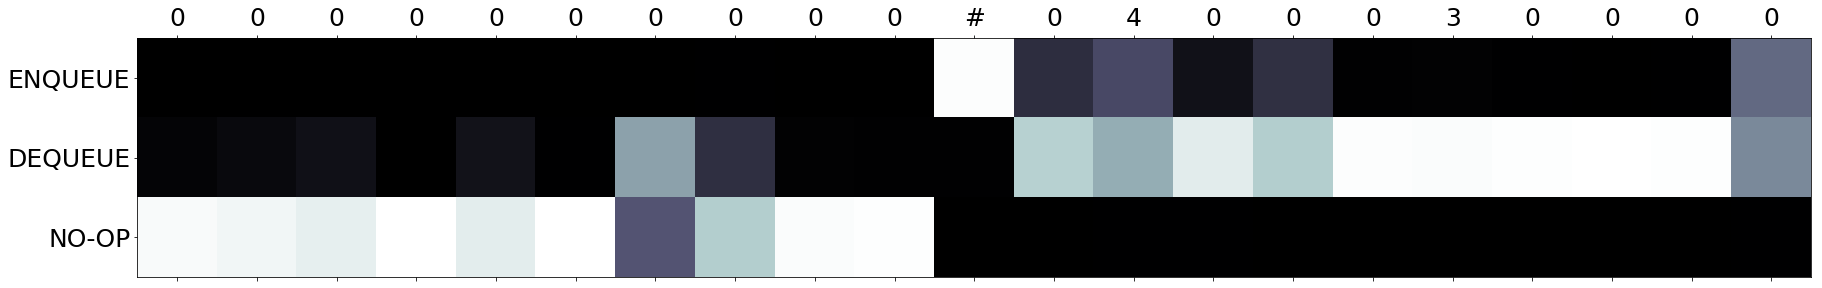

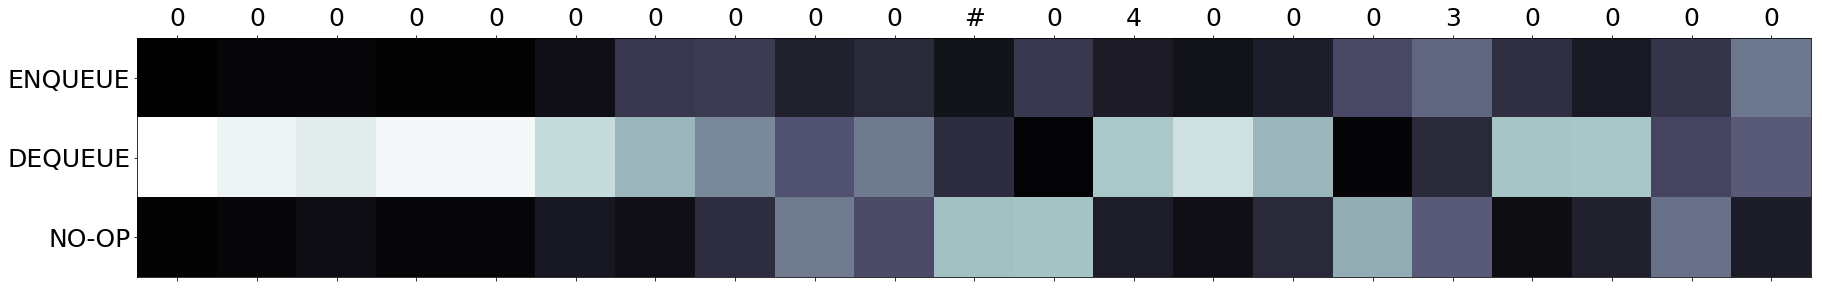

input  : c c c c d a c c a c b a c c a c b d a d # d a d b c a c c a b c a c c a d c c c c
Answer : 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 # 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
predict: 0 0 0 0 0 0 0 0 0 0 # 0 0 0 0 0 # 0 0 0 0 0 0 0 0 # 0 3 3 1 0 3 1 3 3 1 4 3 3 3 3 <eos>


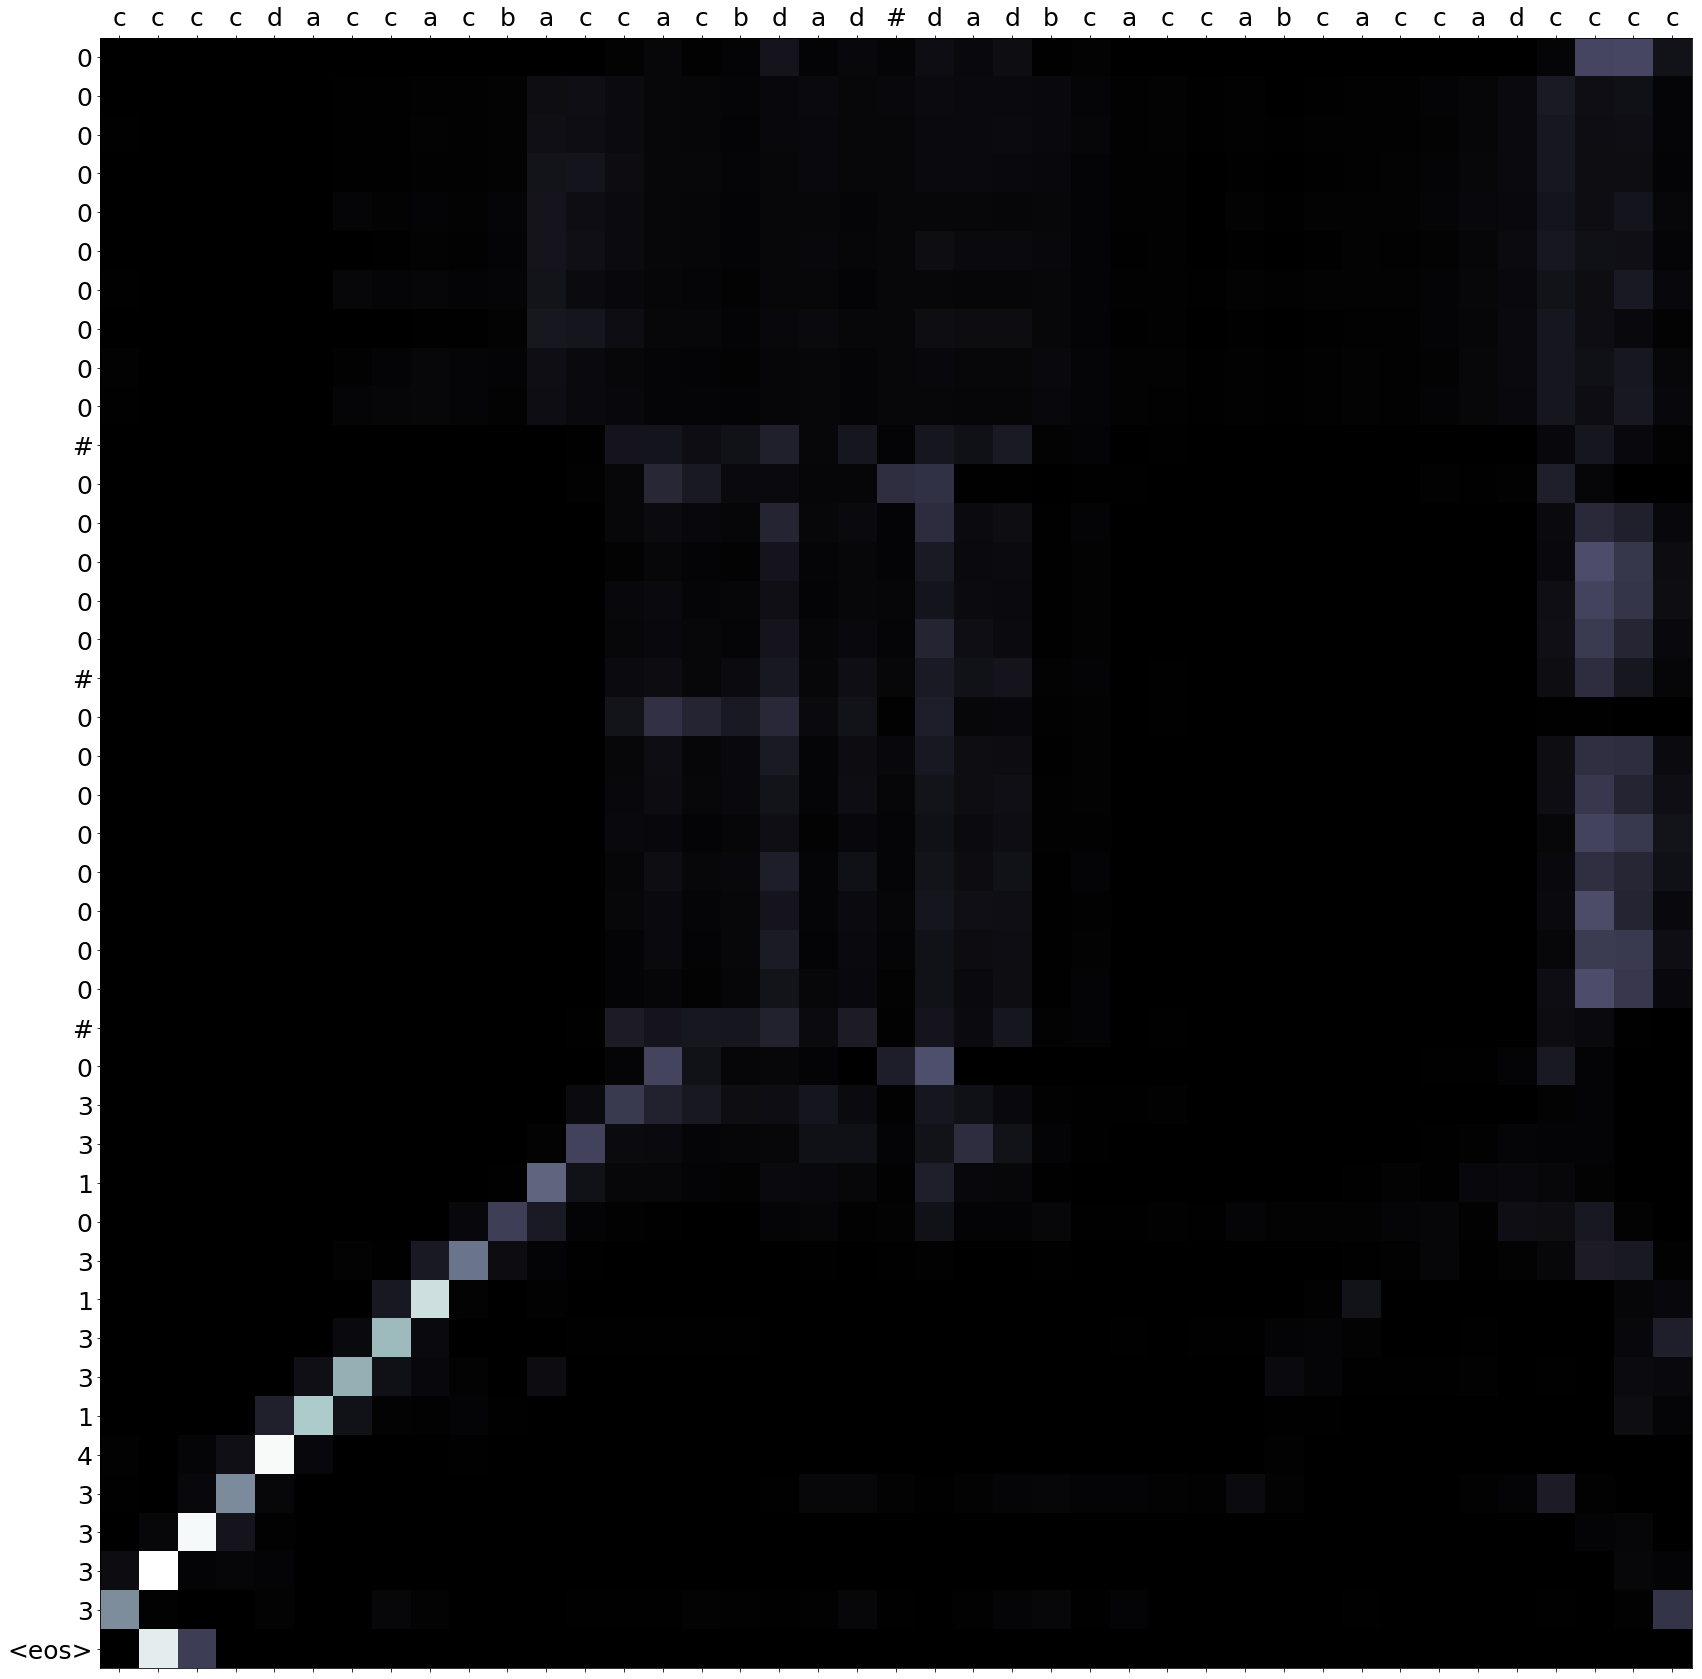

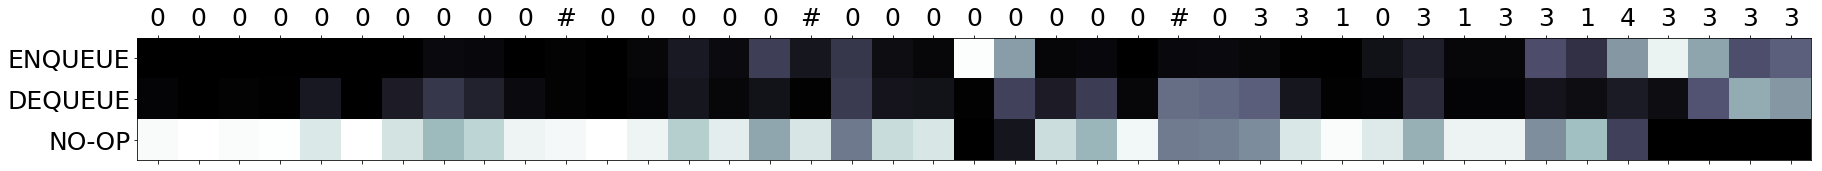

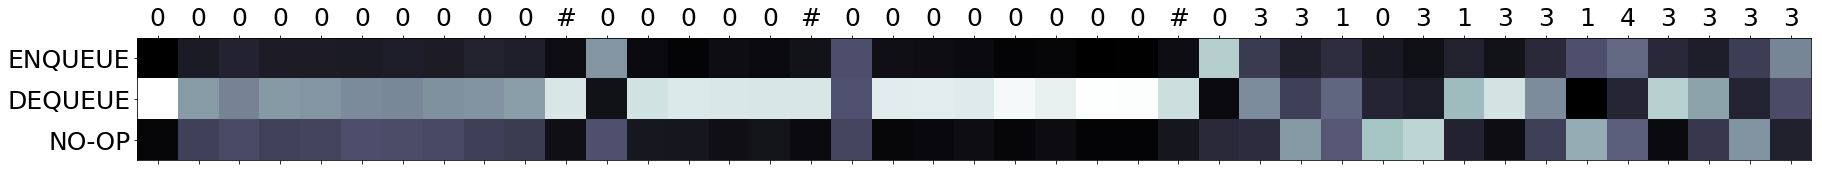

In [11]:
try:
    while True:
        seq_str = input("input  : ")
        seq = "".join(seq_str.strip().split())
        tgt_seq, tgt_att_list, encoder_outputs, action = predictor.predict(seq)
        print("Answer : " + answer_function(seq))
        print("predict: " + " ".join(tgt_seq))
        
        # attention visualize
        for att in tgt_att_list:
            fig = plt.figure(figsize=(30,30))
            ax = fig.add_subplot(111)
            cax = ax.matshow(att, cmap='bone')

            ax.set_xticklabels([''] + list(seq), fontsize=25)
            ax.set_yticklabels([''] + tgt_seq, fontsize=25)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

            
            #plt.savefig(fig_path + '/attn_map.png',format='png',bbox_inches='tight',dpi=300)
        plt.show()
            
        # encoder_action visualize
        each_action = ["ENQUEUE", "DEQUEUE", "NO-OP"]
        encoder_action = action[0].T
        fig1 = plt.figure(figsize=(30,30))
        ax1 = fig1.add_subplot(111)
        cax1 = ax1.matshow(encoder_action, cmap='bone')

        ax1.set_xticklabels([''] + tgt_seq, fontsize=25)
        ax1.set_yticklabels([''] + each_action, fontsize=25)

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
            
        plt.show()
        
        # decoder_action visualize
        decoder_action = action[1].T
        fig2 = plt.figure(figsize=(30,30))
        ax2 = fig2.add_subplot(111)
        cax2 = ax2.matshow(decoder_action, cmap='bone')

        ax2.set_xticklabels([''] + tgt_seq, fontsize=25)
        ax2.set_yticklabels([''] + each_action, fontsize=25)

        ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
            
        plt.show()
        
except KeyboardInterrupt:
    pass